In [1]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
matplotlib.style.use('ggplot')

In [2]:
# Directories
OUTPUT_DIR = '../Outputs/country_clusters/'

# Purpose of the Notebook

Find the beta loadings of the ETFs per country

# Country Data

In [5]:
country_etfs = pd.read_csv('../Data/country_data/ETF_adj_close.csv',index_col=0)
country_etfs.index = pd.to_datetime(country_etfs.index)

In [4]:
# find monthly return - take last date and pct-change
country_returns = country_etfs.groupby(pd.Grouper(freq = 'M')).last().pct_change()
country_returns.index = country_returns.index.to_period('M')

# Fama French

In [6]:
ff5 = pdr.famafrench.FamaFrenchReader('Emerging_5_Factors',start = '2000-01-01').read()[0]

In [6]:
# lets store all betas for FF
betas_dict = {}
results_dict = {}
t_stats_dict = {}

# because of risk free rate discrepancies, the fama regression will only take account of mkt return
ff5_new = ff5.copy()
ff5_new['Mkt'] = ff5_new['Mkt-RF'] + ff5_new['RF']
#cols = ['SMB', 'HML', 'RMW', 'CMA', 'Mkt']
cols = ['SMB', 'HML', 'Mkt']
for c in country_returns:
    y = country_returns.loc[ff5_new.index][c]
    y = y.dropna()
    X = ff5_new.loc[y.index][cols]
    X = sm.add_constant(X)
    model = sm.OLS(y*100, X)
    results = model.fit()
    # Betas
    betas_dict[c] = results.params
    results_dict[c] = results
    # T-stats
    t_stats_dict[c] = results.tvalues
    print(c+', '+y.index.min().strftime('%Y%m'))

Argentina, 201104
Brazil, 200008
Chile, 200712
China, 201105
Colombia, 201307
Egypt, 201003
Greece, 201201
India, 201203
Korea, 200006
Malaysia, 200001
Mexico, 200001
Pakistan, 201505
Peru, 200907
Philippines, 201010
Poland, 201006
Qatar, 201406
Russia, 201012
Saudi Arabia, 201510
South Africa, 200303
Taiwan, 200007
Thailand, 200805
Turkey, 200804
United Arab Emirates, 201406


In [7]:
betas_df = pd.DataFrame(betas_dict)
t_stats_df = pd.DataFrame(t_stats_dict)

## Rolling Betas

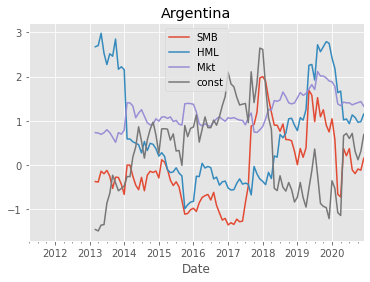

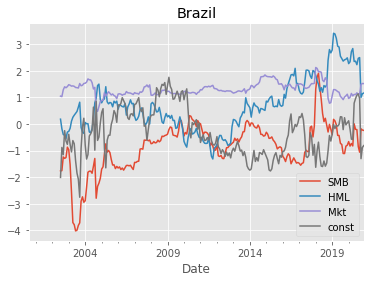

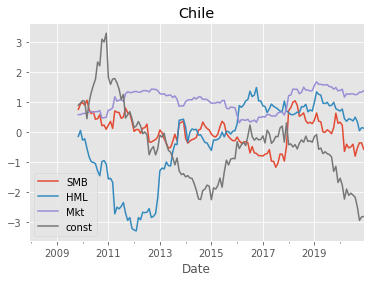

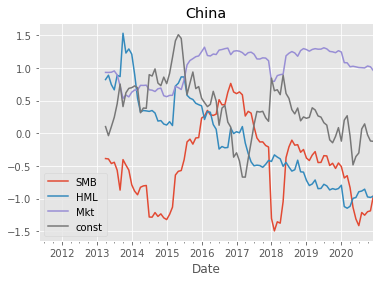

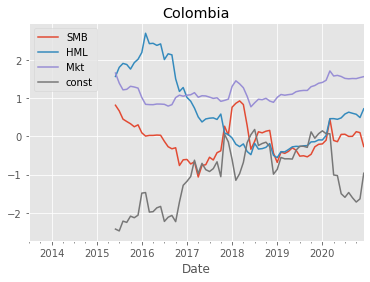

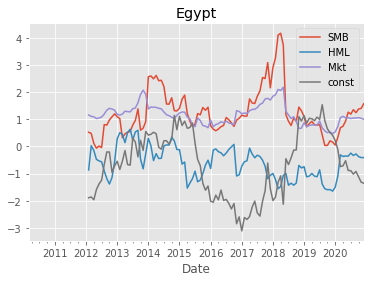

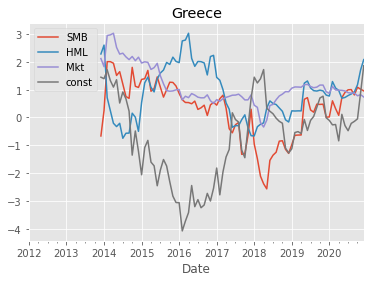

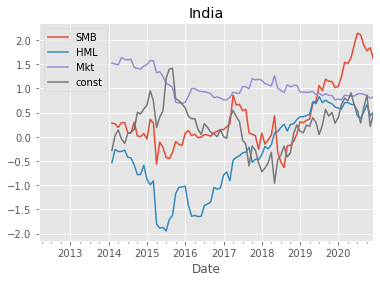

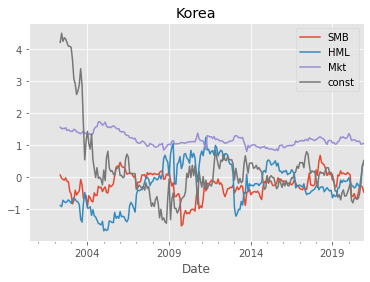

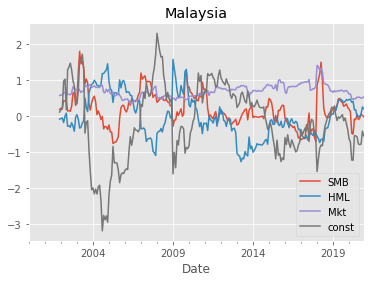

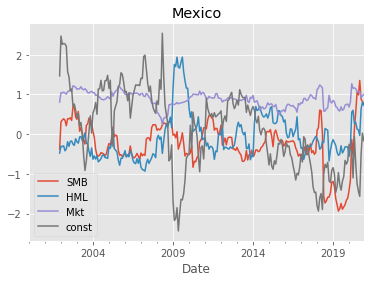

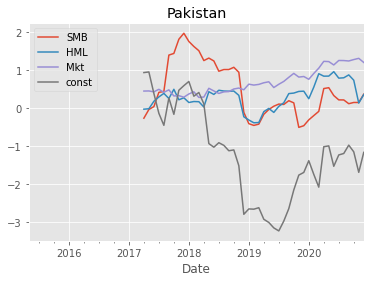

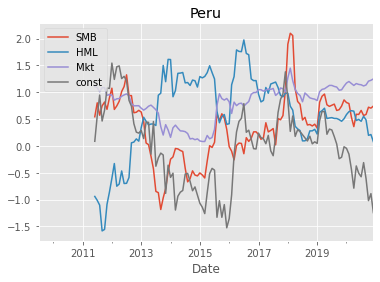

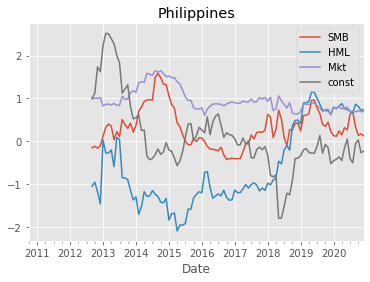

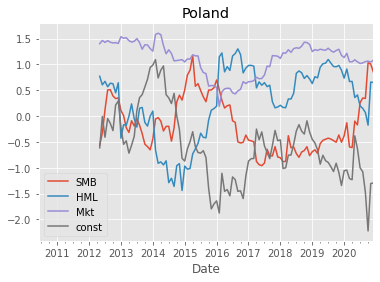

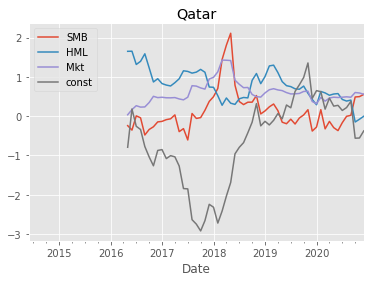

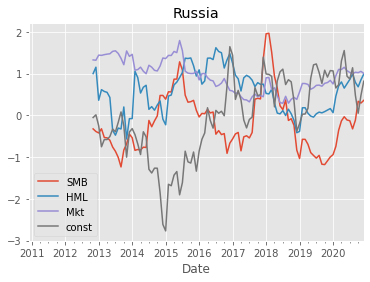

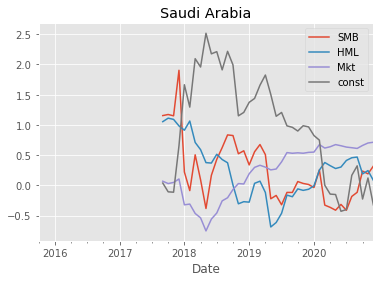

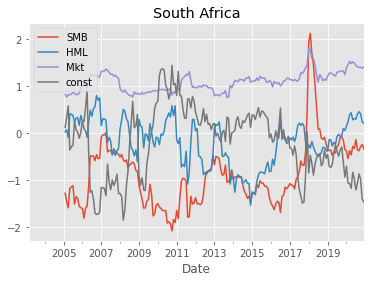

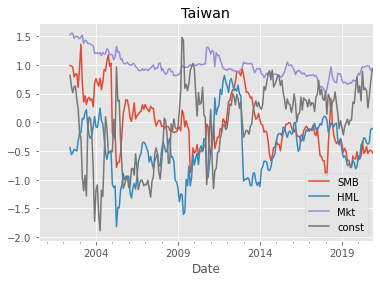

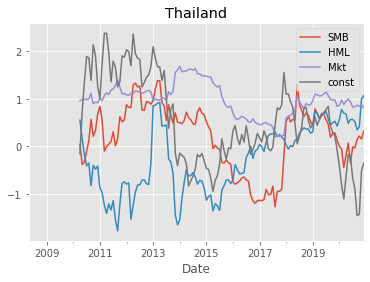

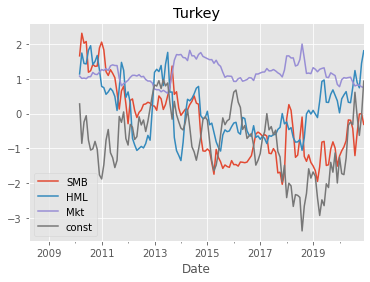

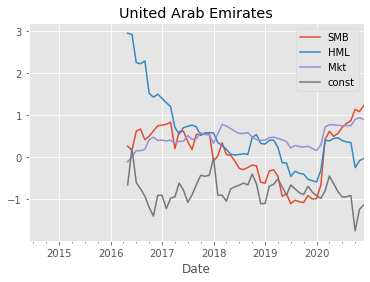

In [14]:
rolling_betas = {}
ff5_new = ff5.copy()
ff5_new['Mkt'] = ff5_new['Mkt-RF'] + ff5_new['RF']
#cols = ['SMB', 'HML', 'RMW', 'CMA', 'Mkt']
cols = ['SMB', 'HML', 'Mkt']
for c in country_returns:
    y = country_returns.loc[ff5_new.index][c]
    y = y.dropna()
    X = ff5_new.loc[y.index][cols]
    X = sm.add_constant(X, prepend=False)
    mod = RollingOLS(y*100, X,window=24)
    rolling_res = mod.fit(params_only = True)
    rolling_res.params.plot(title = c)
    plt.show()
    rolling_betas[c] = rolling_res.params

In [39]:
rolling_df = pd.concat(rolling_betas)
rolling_stats = {}
for cl in cols:
    temp = rolling_df[cl].reset_index().pivot(index = 'Date', columns = 'level_0', values = cl)
    rolling_stats[cl] = {'Mean': temp.mean().mean(), 'Std': temp.std().mean()}
pd.DataFrame(rolling_stats)

,SMB,HML,Mkt
Mean,0.016898,0.136834,0.948941
Std,0.641005,0.721879,0.301459


In [46]:
rolling_stats = {}
for cluster in range(4):
    cntries = equity_etf_clusters[equity_etf_clusters["cluster_label"]==cluster]['Countries'].values
    cluster_betas = {}
    for cl in cols:
        temp = rolling_df.loc[cntries][cl].reset_index().pivot(index = 'Date', columns = 'level_0', values = cl)
        rolling_stats[(cluster,cl)] = {'Mean': temp.mean().mean(), 'Std': temp.std().mean()}
pd.DataFrame.from_dict(rolling_stats)

0                             1                             2  \
           SMB       HML       Mkt       SMB       HML       Mkt       SMB   
Mean  0.432061  0.253859  0.625760 -0.318859  0.537150  1.178744 -0.315952   
Std   0.649127  0.522875  0.325173  0.778572  0.897945  0.347582  1.041645   

                                 3                      
           HML       Mkt       SMB       HML       Mkt  
Mean  0.114764  1.180383  0.011550 -0.076885  0.968562  
Std   0.822721  0.293369  0.546915  0.723033  0.273034

In [48]:
equity_etf_clusters['cluster_label'].value_counts()

3    12
0     5
1     5
2     1
Name: cluster_label, dtype: int64

## Beta Clustering

In [40]:
equity_etf_clusters = pd.read_pickle(OUTPUT_DIR + 'clusters_equity_etf_full.pkl')
equity_etf_clusters.head()

,Countries,cluster_label
0,Pakistan,0
1,Saudi Arabia,0
2,Qatar,0
3,Egypt,0
4,United Arab Emirates,0


In [9]:
# Visualize betas for each cluster of countries
def plot_cluster_betas(clusters_df, betas_df, cluster_n, ylim, ytitle):
    # Plot betas for each cluster
    cluster_list = list(clusters_df[clusters_df['cluster_label']==cluster_n]['Countries'])
    betas_df_tmp = betas_df[cluster_list]
    
    #no_const = betas_df_tmp.T[betas_df_tmp.T.columns[~betas_df_tmp.T.columns.isin(['const'])]]
    betas_df_tmp.T.plot(kind='bar', rot=0, figsize=(12,2))
    plt.legend(loc='upper left')
    plt.ylabel(ytitle)
    plt.ylim(-ylim,ylim)

def plot_multiple_clusters(clusters_df, betas_df, ylim, ytitle):
    all_cluster_labels = list(clusters_df['cluster_label'].unique())
    #fig, ax = plt.subplots(nrows=len(all_cluster_labels), constrained_layout=True, figsize=(12,8))
    for label_ in all_cluster_labels:
        plot_cluster_betas(clusters_df, betas_df, label_, ylim, ytitle)

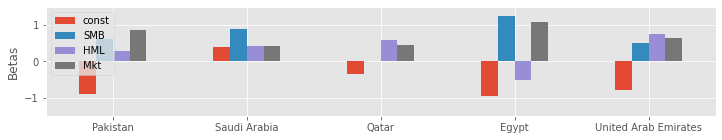

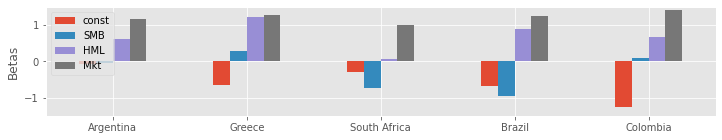

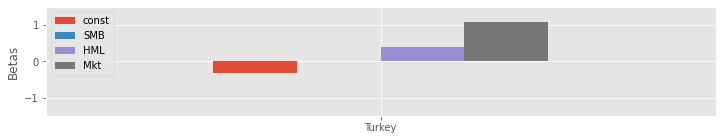

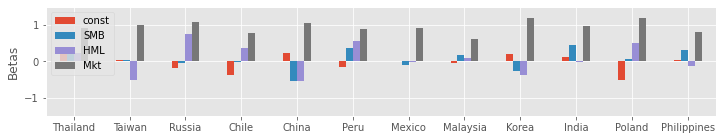

In [10]:
plot_multiple_clusters(equity_etf_clusters, betas_df, 1.5, ytitle='Betas')

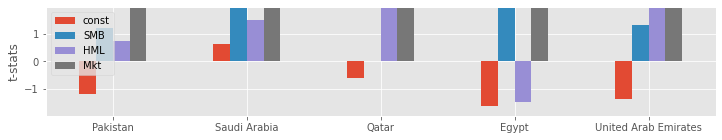

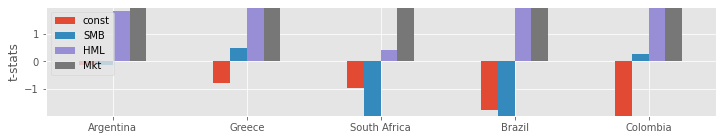

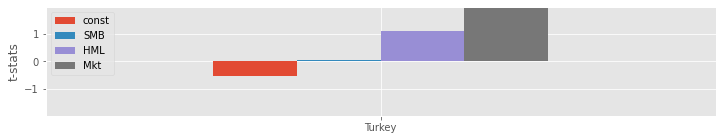

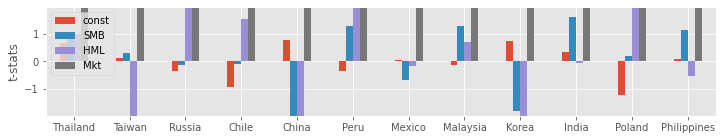

In [11]:
plot_multiple_clusters(equity_etf_clusters, t_stats_df, 1.96, ytitle='t-stats')